In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
import numpy as np


In [46]:
df = pd.read_csv('../data/raw/credit_card_transactions.csv')
df.head()

,TransactionID,Time,Amount,CardholderName,MerchantName,MCC,Location,Device,IPAddress,TransactionSpeed,Fraud
0,1,2025-03-09 06:23:57,83.54,Sarah Murray,Oconnor-Hughes,5411,Longtown,Android,102.247.49.50,38.17,0
1,2,2025-02-14 05:17:36,805.88,Alexander Brooks,Reed PLC,5261,Woodsland,POS,153.157.50.7,49.84,0
2,3,2024-05-03 15:28:52,450.49,Harold Perez,Berry LLC,5261,Jessicatown,iOS,151.174.154.123,48.79,0
3,4,2024-05-03 09:01:14,782.39,Rebecca Davis,Berg Inc,5968,North Krystalburgh,Android,130.70.79.149,8.71,0
4,5,2025-04-24 17:24:39,713.02,Lauren Benson DDS,King-Gaines,5968,East Danielletown,Android,195.136.16.190,17.16,0


# Definir preprocessing para las columnas

In [45]:
amount_log_scaler = FunctionTransformer(np.log1p, validate=False)
amount_robust_scaler = RobustScaler()

amount_pipe = Pipeline([
    ('log_scaler', amount_log_scaler),
    ('robust_scaler', amount_robust_scaler)
])

speed_scaler = StandardScaler()
mcc_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Pre-Procesar

In [48]:
pre_processor = ColumnTransformer([
    ('amount', amount_pipe, ['Amount']),
    ('speed', speed_scaler, ['TransactionSpeed']),
    ('mcc', mcc_encoder, ['MCC'])
])

In [49]:
# eliminar columnas innecesarias
X = df.drop(columns=['TransactionID', 'Fraud'])
y = df['Fraud'] # target

In [50]:
X_processed = pre_processor.fit_transform(X)

In [51]:
mcc_cols = list(pre_processor.named_transformers_['mcc'].get_feature_names_out(['MCC']))

In [52]:
def compare_distributions(original, processed, title_raw, title_scaled, bins=50):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(original, bins=bins, kde=True, color="skyblue", ax=axes[0])
    axes[0].set_title(title_raw)
    axes[0].grid(True)

    sns.histplot(processed, bins=bins, kde=True, color="salmon", ax=axes[1])
    axes[1].set_title(title_scaled)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

In [53]:
X_df_proc = pd.DataFrame(X_processed, columns=['Amount', 'TransactionSpeed'] + mcc_cols)

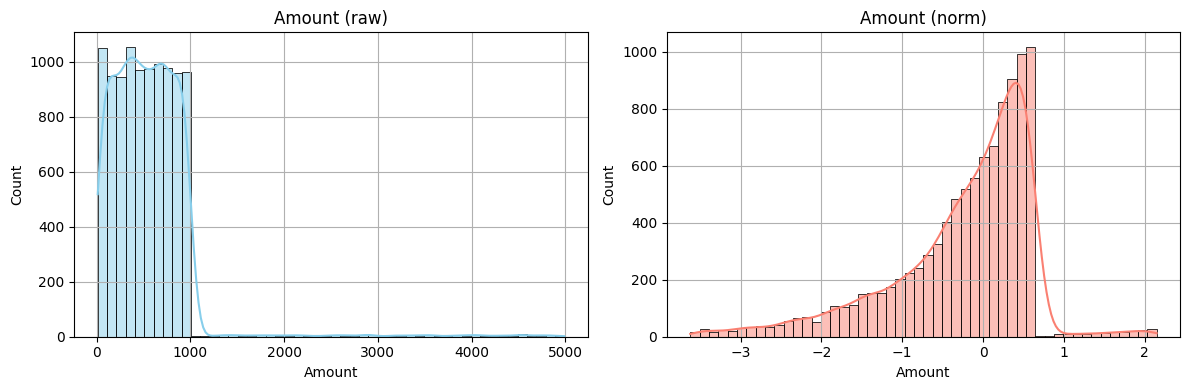

In [54]:
compare_distributions(df["Amount"], X_df_proc["Amount"], "Amount (raw)", "Amount (norm)")

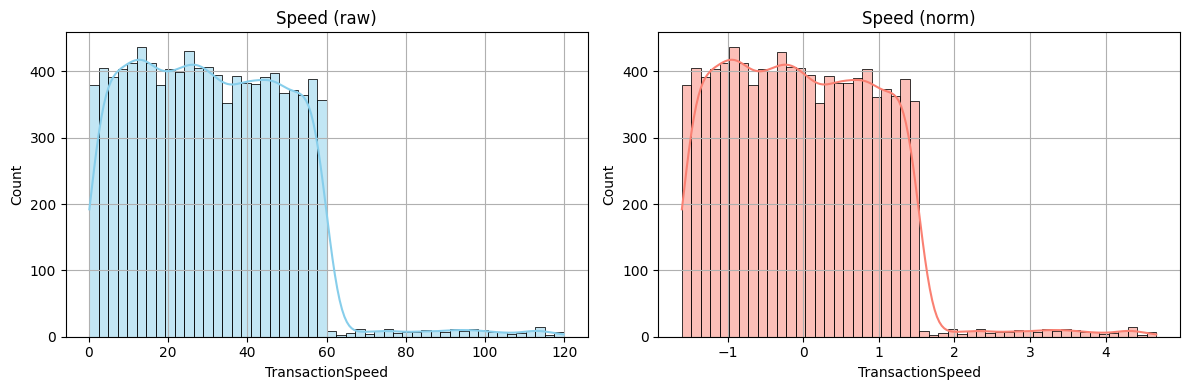

In [55]:
compare_distributions(df["TransactionSpeed"], X_df_proc["TransactionSpeed"], "Speed (raw)", "Speed (norm)")

In [56]:
X_df_proc['Fraud'] = y.values
X_df_proc.to_csv("../data/process/data.csv", index=False)